# RNN Framework for Graph Node Degree Prediction

This notebook implements a Recurrent Neural Network (RNN) framework that predicts node degrees based on node types in a graph. The input consists of pathways generated by a random walker traversing the graph.

In [25]:
# Import required libraries
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Dict, Tuple
import os
from hetmatpy.hetmat import hetmat_from_graph
from hetmatpy.hetmat import HetMat
import hetnetpy
import networkx as nx

## 1. Load Hetionet


In [26]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetnetpy.readwrite.read_graph(url)




In [44]:
nodes = graph.get_nodes()
# Get total number of nodes
num_nodes = len(list(nodes))
print(f"Total number of nodes: {num_nodes}")

# Get total number of edges
edges = graph.get_edges()
num_edges = len(list(edges))
print(f"Total number of edges: {num_edges}")

Total number of nodes: 47031
Total number of edges: 2250197


In [77]:
# Convert hetionet graph to networkx graph
G_nx = nx.MultiGraph()

# Add nodes with attributes from hetionet graph
for node in graph.get_nodes():
    G_nx.add_node(node.identifier, 
                  node_type=node.metanode.identifier,
                  name=node.name,
                  data=node.data)

# Add edges from hetionet graph
for edge in graph.get_edges():
    source = edge.source.identifier
    target = edge.target.identifier
    G_nx.add_edge(source, target, 
                  edge_type=edge.metaedge.kind,
                  data=edge.data)

print(f"Created NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges")

Created NetworkX graph with 47031 nodes and 2250197 edges


In [78]:
# Check for disease nodes in G_nx
disease_nodes = [n for n, d in G_nx.nodes(data=True) if d.get('node_type') == 'Disease']
print(f"Number of disease nodes: {len(disease_nodes)}")
print("Sample disease nodes:")
for n in disease_nodes[:5]:
    print(n)

Number of disease nodes: 137
Sample disease nodes:
DOID:14227
DOID:9352
DOID:8778
DOID:5612
DOID:363


In [89]:
import random
from collections import Counter
import pandas as pd
def sample_gene_anatomy_disease_walks(G_nx, walk_length=3, num_walks=10000):
    gene_nodes = [n for n, d in G_nx.nodes(data=True) if d.get('node_type') == 'Gene']
    walks = []
    for _ in range(num_walks):
        if not gene_nodes:
            break
        start = random.choice(gene_nodes)
        walk = [start]
        current = start
        # First step: only to anatomy nodes (undirected)
        anatomy_neighbors = [n for n in G_nx.neighbors(current) if G_nx.nodes[n].get('node_type') == 'Anatomy']
        if not anatomy_neighbors:
            continue
        next_node = random.choice(anatomy_neighbors)
        walk.append(next_node)
        current = next_node
        # Second step: only to disease nodes (undirected)
        disease_neighbors = [n for n in G_nx.neighbors(current) if G_nx.nodes[n].get('node_type') == 'Disease']
        if not disease_neighbors:
            continue
        next_node = random.choice(disease_neighbors)
        walk.append(next_node)
        # Only keep walks of correct length
        if len(walk) == walk_length:
            walks.append(walk)
    return walks

# Sample 10000 random walks of length 3: Gene -> Anatomy -> Disease (undirected)
walks = sample_gene_anatomy_disease_walks(G_nx, walk_length=3, num_walks=10000)

# Get node types for each node in walks
walk_types = []
for walk in walks:
    types = [G_nx.nodes[node]['node_type'] for node in walk]
    walk_types.append('->'.join(types))

# Count unique metapaths
metapath_counts = Counter(walk_types)

# Convert to DataFrame for better visualization
metapath_df = pd.DataFrame.from_dict(metapath_counts, orient='index', columns=['Count'])
metapath_df.index.name = 'Metapath'
metapath_df = metapath_df.sort_values('Count', ascending=False)

print(f"Number of Gene->Anatomy->Disease walks: {len(walks)}")
print("Top metapaths in walks:")
print(metapath_df)

Number of Gene->Anatomy->Disease walks: 8552
Top metapaths in walks:
                        Count
Metapath                     
Gene->Anatomy->Disease   8552


In [90]:
def calculate_dwpc(G_nx, walks):
    dwpc_values = []
    for walk in walks:
        # Get degrees of nodes in the path
        degrees = [G_nx.degree(node) for node in walk]
        # Convert degrees to their inverse square root for later geometric mean calculation
        degrees = [1 / (d ** 0.5) for d in degrees]
        # Calculate DWPC as the geometric mean of node degrees
        dwpc = np.power(np.prod(degrees), 1/len(degrees))
        dwpc_values.append(dwpc)
    
    return torch.tensor(dwpc_values)

# Calculate DWPC for the sample walks
dwpc_values = calculate_dwpc(G_nx, walks)

# Create a DataFrame to show paths and their DWPC values
results_df = pd.DataFrame({
    'Path': ['->'.join(str(node) for node in walk) for walk in walks],
    'DWPC': dwpc_values.numpy()
})

print("Sample paths and their DWPC values:")
print(results_df.head())
print(f"\nTotal paths analyzed: {len(walks)}")
print(f"Average DWPC: {dwpc_values.mean():.2f}")

Sample paths and their DWPC values:
                                Path      DWPC
0   1144->UBERON:0000948->DOID:10763  0.029440
1  55230->UBERON:0000043->DOID:13189  0.054860
2    4656->UBERON:0001008->DOID:4045  0.041000
3  146861->UBERON:0000178->DOID:4989  0.057996
4   27178->UBERON:0001004->DOID:1324  0.042643

Total paths analyzed: 8552
Average DWPC: 0.04


In [94]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ...existing code for data preparation...

class RNN_DWPC(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out.squeeze()

# Hyperparameters
input_dim = num_node_types
hidden_dim = 64
num_layers = 2
dropout = 0.3

model = RNN_DWPC(input_dim, hidden_dim, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(10):
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("Training complete. The RNN can now estimate DWPCs for Gene-Anatomy-Disease paths.")

Epoch 1, Loss: 0.0799
Epoch 2, Loss: 0.1064
Epoch 3, Loss: 0.1653
Epoch 4, Loss: 0.0972
Epoch 5, Loss: 0.0497
Epoch 6, Loss: 0.0857
Epoch 7, Loss: 0.0889
Epoch 8, Loss: 0.1072
Epoch 9, Loss: 0.0942
Epoch 10, Loss: 0.1153
Training complete. The RNN can now estimate DWPCs for Gene-Anatomy-Disease paths.
Epoch 6, Loss: 0.0857
Epoch 7, Loss: 0.0889
Epoch 8, Loss: 0.1072
Epoch 9, Loss: 0.0942
Epoch 10, Loss: 0.1153
Training complete. The RNN can now estimate DWPCs for Gene-Anatomy-Disease paths.


In [95]:
# Generate new test walks
test_walks = sample_gene_anatomy_disease_walks(G_nx, walk_length=3, num_walks=100)

# Convert test walks to input format
test_X = torch.tensor([[node_type_to_idx[G_nx.nodes[node]['node_type']] for node in walk] 
                      for walk in test_walks], dtype=torch.long)

# Calculate actual DWPC values for test walks
test_y = calculate_dwpc(G_nx, test_walks)

# Set model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    test_predictions = model(test_X)

# Calculate MSE
test_mse = nn.MSELoss()(test_predictions, test_y)

# Calculate additional metrics
mae = torch.mean(torch.abs(test_predictions - test_y))
relative_error = torch.mean(torch.abs(test_predictions - test_y) / test_y)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Mean Relative Error: {relative_error:.4f}")

# Create DataFrame with results
test_results = pd.DataFrame({
    'Path': ['->'.join(str(node) for node in walk) for walk in test_walks],
    'Actual DWPC': test_y.numpy(),
    'Predicted DWPC': test_predictions.numpy()
})

print("\nSample predictions:")
print(test_results.head())

Test MSE: 0.2150
Test MAE: 0.4634
Mean Relative Error: 11.4505

Sample predictions:
                                Path  Actual DWPC  Predicted DWPC
0    3953->UBERON:0001348->DOID:9970     0.066406        0.507848
1  64689->UBERON:0002368->DOID:10763     0.031039        0.507848
2      56->UBERON:0000007->DOID:1459     0.049510        0.507848
3    885->UBERON:0001064->DOID:14268     0.135778        0.507848
4   23130->UBERON:0001890->DOID:5419     0.036051        0.507848


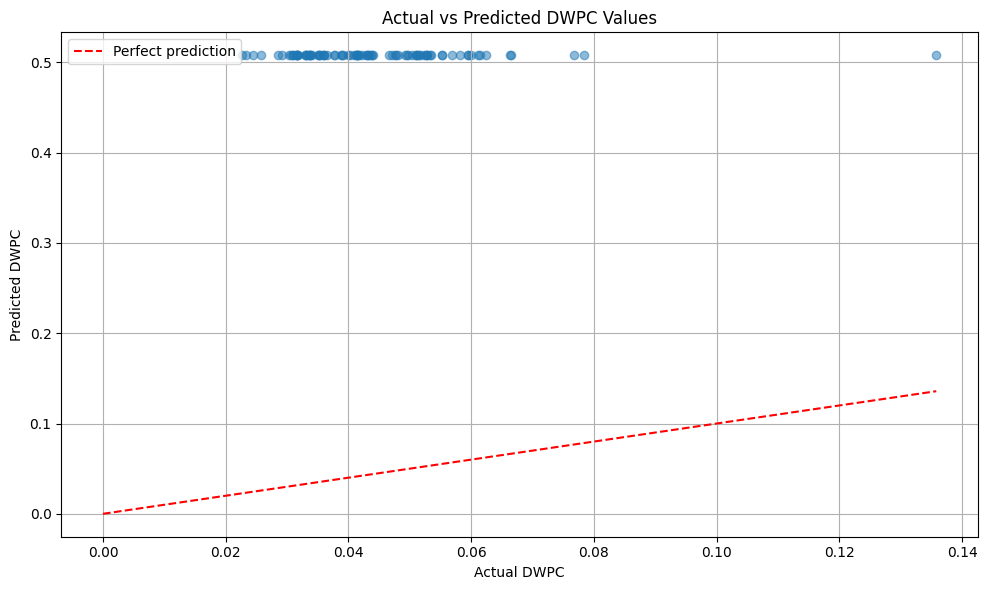

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(test_results['Actual DWPC'], test_results['Predicted DWPC'], alpha=0.5)
plt.plot([0, test_results['Actual DWPC'].max()], [0, test_results['Actual DWPC'].max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual DWPC')
plt.ylabel('Predicted DWPC')
plt.title('Actual vs Predicted DWPC Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = PathDataset(X_train, y_train)
val_dataset = PathDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Update dropout and optimizer
dropout = 0.5
model = RNN_DWPC(input_dim, hidden_dim, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop with validation and early stopping
best_val_loss = float('inf')
for epoch in range(20):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            val_preds = model(batch_X)
            val_loss = criterion(val_preds, batch_y)
            val_losses.append(val_loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}")
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

# Load best model
model.load_state_dict(best_model_state)
print("Training complete. Best model loaded.")

ModuleNotFoundError: No module named 'sklearn'